In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import click
import os
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import logging
import random
import pickle
from sabcom.helpers import generate_district_data, what_informality
from sabcom.environment import Environment

from datetime import datetime, timedelta

from helpers.estimation import ls_cost_function, constrNM
from helpers.datecalculations import days_between, generate_new_series
pd.options.mode.chained_assignment = None 

# Estimating uncertain parameters ABM 

1. get excess fatality curve
2. translate curve to same timeline as simulation
3. define parameters and bounds 
4. estimate uncertain params for Cape Town
5. estimate uncertain params for Johonnesburg 

## 1 get excess fatality curve

In [19]:
excess_deaths = pd.read_excel('samrc_excess_deaths_26_08_2020.xlsx', index_col=0)

Total excess deaths are: 

In [20]:
print('total excess deaths: ', 'CT: ', int(round(excess_deaths['CPT'].sum())), ' JHN: ', int(round(excess_deaths['JHN'].sum())))

total excess deaths:  CT:  3681  JHN:  3638


The peak of excess deaths is: 

In [21]:
peak_ct = str(excess_deaths['CPT'].idxmax())[:-9]
peak_jb = str(excess_deaths['JHN'].idxmax())[:-9]
first_ct = '2020-03-27' # source: https://www.news24.com/news24/southafrica/news/first-covid-19-deaths-we-mourn-as-a-province-and-country-western-cape-premier-alan-winde-20200327
first_jb = '2020-03-30' # source https://www.news24.com/news24/southafrica/news/coronavirus-79-year-old-man-is-gautengs-first-covid-19-death-20200331

In [22]:
print('peak excess death day: ', 'CT: ', days_between(peak_ct, first_ct), ' JHN: ', days_between(peak_jb, first_jb))

peak excess death day:  CT:  75  JHN:  100


In [23]:
excess_deaths.head(3)

,CPT,JHN
2020-05-06,30.000000,NaN
2020-05-13,122.456314,NaN
2020-05-20,292.934406,NaN


# 2 Translate curve to same time line as simulation

First, smooth out excess death curves to daily period: 

In [24]:
# divide deaths evenly between dates 
# data point 1 and 2 
extended_excess_deaths = {}
for city in ['CPT', 'JHN']:
    excess_death_data = []
    for x in range(len(excess_deaths)-1):
        days = days_between(str(excess_deaths.index[x+1])[:-9], str(excess_deaths.index[x])[:-9])
        spread_out_data = [excess_deaths[city].iloc[x] / days for y in range(days)]
        excess_death_data.append(spread_out_data)
    excess_death_extended = [item for sublist in excess_death_data for item in sublist]
    excess_death_extended = pd.Series(excess_death_extended).ewm(span = 1).mean()
    extended_excess_deaths[city] = excess_death_extended

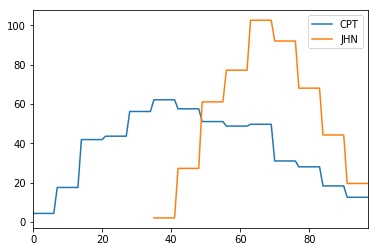

In [25]:
pd.DataFrame(extended_excess_deaths).plot()

In [26]:
gauteng_cases = pd.read_csv('Gauteng_Page 1_Time series.csv')
western_cape_cases = pd.read_csv('Western Cape  Page Design_Page 1_Time series.csv') 
western_cape_cases['Date'] = [datetime.strptime(western_cape_cases['Date'].iloc[x], "%b %d, %Y") for x in range(len(western_cape_cases['Date']))]
gauteng_cases['Date'] = [datetime.strptime(gauteng_cases['Day'].iloc[x], "%b %d, %Y") for x in range(len(gauteng_cases['Day']))]
joburg_cases = pd.Series([0 for x in range(9)] + [x for x in gauteng_cases['Johannesburg']])
city_cases = western_cape_cases[['Date', 'City Of Cape Town']]
city_cases['Johannesburg'] = joburg_cases
city_cases.index = city_cases['Date']
city_cases = city_cases[['City Of Cape Town', 'Johannesburg']].ewm(span = 10).mean()

The start date is the first date of the Cape Town simulation while the end date is the last date of the simulation of Joburg. 

In [27]:
date1_ct = city_cases['City Of Cape Town'][city_cases['City Of Cape Town'].cumsum() > 310].index[0]
date1_jhn = city_cases['Johannesburg'][city_cases['Johannesburg'].cumsum() > 310].index[0]

start_date = date1_ct 
end_date = date1_jhn + timedelta(days=350)

Set index equal to ecess death days counted

In [28]:
extended_excess_deaths['CPT'].index = [excess_deaths.index[0] + timedelta(days=x) for x in extended_excess_deaths['CPT'].index]
extended_excess_deaths['JHN'].index = [excess_deaths.index[0] + timedelta(days=x) for x in extended_excess_deaths['JHN'].index]

In [29]:
# how much to add at start: first date - start date 
# days_between(str(excess_deaths.index[x+1])[:-9], str(excess_deaths.index[x])[:-9])
ct_extra_days_start = days_between(str(start_date)[:-9], str(extended_excess_deaths['CPT'].index[0])[:-9]) 
ct_extra_days_end = days_between(str(extended_excess_deaths['CPT'].index[-1])[:-9], str(end_date)[:-9], )

In [30]:
# create time date stamps with timedelta(days=1)
all_dates = [start_date + timedelta(days=x) for x in range(0, ct_extra_days_start)] + [extended_excess_deaths['CPT'].index[0] + timedelta(days=x) for x in range(len(extended_excess_deaths['CPT']))] + [extended_excess_deaths['CPT'].index[-1] + timedelta(days=x) for x in range(1, ct_extra_days_end + 1)]#.iloc[-1]

In [31]:
master_data = pd.DataFrame({
    'excess_d_ct': generate_new_series(extended_excess_deaths['CPT'], all_dates),
    'excess_d_jhn': generate_new_series(extended_excess_deaths['JHN'], all_dates),
})
master_data.index = all_dates

In [34]:
master_data.to_csv('excess_death_curves.csv')

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.285714285714286,
 4.285714285714286,
 4.285714285714286,
 4.285714285714286,
 4.285714285714286,
 4.285714285714286,
 4.285714285714286,
 17.493759127662283,
 17.493759127662283,
 17.493759127662283,
 17.493759127662283,
 17.493759127662283,
 17.493759127662283,
 17.493759127662283,
 41.8477723255592,
 41.8477723255592,
 41.8477723255592,
 41.8477723255592,
 41.8477723255592,
 41.8477723255592,
 41.8477723255592,
 43.5757374021873,
 43.5757374021873,
 43.5757374021873,
 43.5757374021873,
 43.5757374021873,
 43.5757374021873,
 43.5757374021873,
 56.14066424926025,
 56.14066424926025,
 56.14066424926025,
 56.14066424926025,
 56.14066424926025,
 56.14066424926025,
 56.14066424926025,
 62.08516230884758,
 62.08516230884758,
 62.08516230884758,
 62.08516230884758,
 62.08516230884758,
 62.08516230884758,
 62.08516230884758,
 57.50367465414921,
 57.50367465414921,
 57.503674654

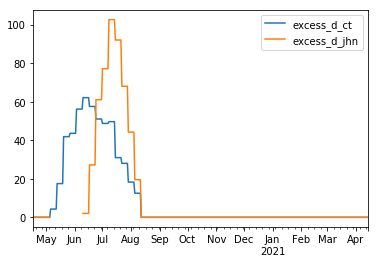

In [32]:
master_data.plot()

# 3 Define parameters and bounds

In [16]:
problem = {
    'num_vars': 8,
    'names': ["probability_transmission", "total_initial_infections", "physical_distancing_multiplier", 
           'likelihood_awareness', "gathering_max_contacts", 'private_shock_stdev', 'weight_private_signal', 
              'visiting_recurring_contacts_multiplier'],
    'bounds': [[0.02, 0.04], [30, 350], [0.3, 0.999],
            [0.40, 0.99], [5.0, 50.0], [0.02, 0.7], [0.05, 0.7], [0.2, 0.95]],
    'initial': [0.03, 100.0, 0.80, 0.95, 12, 0.05, 0.1, 0.8]
}

In [24]:
#[0.04, 300.0, 0.80, 0.98, 12, 0.05, 0.1, 0.8]

[3.00000000e-02, 1.00000000e+02, 8.00000000e-01, 9.50000000e-01,
        1.20000000e+01, 5.00000000e-02, 1.59477715e-01, 8.00000000e-01]

# 4 Define model

In [65]:
def runner(environment, initial_infections, seed, data_folder='output_data/',
           data_output=False, calculate_r_naught=False):
    """
    This function is used to run / simulate the model.

    :param environment: contains the parameters and agents, Environment object
    :param initial_infections: contains the Wards and corresponding initial infections, Pandas DataFrame
    :param seed: used to initialise the random generators to ensure reproducibility, int
    :param data_folder:  string of the folder where data output files should be created
    :param data_output:  can be 'csv', 'network', or False (for no output)
    :param calculate_r_naught: set to True to calculate the R0 that the model produces given a single infected agent
    :return: environment object containing the updated agents, Environment object
    """
    # set monte carlo seed
    np.random.seed(seed)
    random.seed(seed)

    # create sets for all agent types
    dead = []
    recovered = []
    critical = []
    sick_with_symptoms = []
    sick_without_symptoms = []
    exposed = []
    susceptible = [agent for agent in environment.agents]
    compliance = []

    # 4 Initialisation of infections
    # here either a fixed initial agent can be infected once to calculate R0
    if calculate_r_naught:
        initial_infected = []
        chosen_agent = environment.agents[environment.parameters['init_infected_agent']]
        chosen_agent.status = 'e'
        initial_infected.append(chosen_agent)
        exposed.append(chosen_agent)
        susceptible.remove(chosen_agent)
    # otherwise infect a set of agents based on the locations of observed infections
    else:
        initial_infections = initial_infections.sort_index()
        cases = [x for x in initial_infections['Cases']]
        probabilities_new_infection_district = [float(i) / sum(cases) for i in cases]

        initial_infected = []
        # select districts with probability
        chosen_districts = list(np.random.choice(environment.districts,
                                                 environment.parameters['total_initial_infections'],
                                                 p=probabilities_new_infection_district))
        # count how often a district is in that list
        chosen_districts = {distr: min(len(environment.district_agents[distr]),
                                       chosen_districts.count(distr)) for distr in chosen_districts}

        for district in chosen_districts:
            # infect appropriate number of random agents
            chosen_agents = np.random.choice(environment.district_agents[district], chosen_districts[district],
                                             replace=False)
            categories = ['e', 'i1', 'i2']
            for chosen_agent in chosen_agents:
                new_status = random.choice(categories)
                chosen_agent.status = new_status
                # give i2 days a random value to avoid an unrealistic wave of initial critical cases and deaths
                if new_status == 'e':
                    chosen_agent.incubation_days = np.random.randint(0, environment.parameters['exposed_days'])
                    exposed.append(chosen_agent)
                elif new_status == 'i1':
                    chosen_agent.asymptomatic_days = np.random.randint(0, environment.parameters['asymptom_days'])
                    sick_without_symptoms.append(chosen_agent)
                elif new_status == 'i2':
                    chosen_agent.sick_days = np.random.randint(0, environment.parameters['symptom_days'])
                    sick_with_symptoms.append(chosen_agent)

                susceptible.remove(chosen_agent)

    for t in range(environment.parameters["time"]):
        print(t)
        # Check if the health system is not overburdened
        if len(critical) / len(environment.agents) > environment.parameters["health_system_capacity"]:
            health_overburdened_multiplier = environment.parameters["no_hospital_multiplier"]
        else:
            health_overburdened_multiplier = 1.0

        # create truncnorm generator to generate shocks for this period based on current stringency index
        lower, upper = -(environment.stringency_index[t] / 100), (1 - (environment.stringency_index[t] / 100))
        mu, sigma = 0.0, environment.parameters['private_shock_stdev']
        truncnorm_shock_generator = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

        # 5 update status loop
        for agent in susceptible + exposed + sick_without_symptoms + sick_with_symptoms + critical + recovered:
            # construct deGroot signals
            # save compliance to previous compliance
            agent.previous_compliance = agent.compliance

            # find indices from neighbour agents
            neighbours_to_learn_from = [environment.agents[x] for x in environment.network.neighbors(agent.name)]

            private_signal = environment.stringency_index[t] / 100 + truncnorm_shock_generator.rvs(1)[0]
            if neighbours_to_learn_from: # sometimes an agent has no neighbours
                neighbour_signal = np.mean([x.previous_compliance for x in neighbours_to_learn_from])
            else:
                neighbour_signal = private_signal

            agent.compliance = (1 - agent.informality) * \
                               (environment.parameters['weight_private_signal'] * private_signal +
                                (1 - environment.parameters['weight_private_signal']) * neighbour_signal)

            if agent.status == 'e':
                agent.exposed_days += 1
                # some agents will become infectious but do not show agents while others will show symptoms
                if agent.exposed_days > environment.parameters["exposed_days"]:
                    if np.random.random() < environment.parameters["probability_symptomatic"]:
                        agent.status = 'i2'
                        exposed.remove(agent)
                        sick_with_symptoms.append(agent)
                    else:
                        agent.status = 'i1'
                        exposed.remove(agent)
                        sick_without_symptoms.append(agent)

            if agent.status == 'i1':
                agent.asymptomatic_days += 1
                # asymptomatic agents all recover after some time
                if agent.asymptomatic_days > environment.parameters["asymptom_days"]:
                    # calculate R0 here if the first agent recovers
                    if calculate_r_naught and agent in initial_infected:
                        print(t, ' patient zero recovered or dead with R0 = ', agent.others_infects_total)
                        return agent.others_infects_total

                    agent.status = 'r'
                    sick_without_symptoms.remove(agent)
                    recovered.append(agent)

            elif agent.status == 'i2':
                # check if the agent is aware that is is infected here and set compliance to 1.0 if so
                likelihood_awareness = environment.parameters['likelihood_awareness']# * (
                            # environment.stringency_index[t] / 100) * (
                            #                        1 - agent.informality)
                if np.random.random() < likelihood_awareness:
                    agent.compliance = 1.0

                agent.sick_days += 1
                # some symptomatic agents recover
                if agent.sick_days > environment.parameters["symptom_days"]:
                    if np.random.random() < environment.parameters["probability_critical"][agent.age_group]:
                        agent.status = 'c'
                        sick_with_symptoms.remove(agent)
                        critical.append(agent)
                    else:
                        # calculate R0 here if the first agent recovers
                        if calculate_r_naught and agent in initial_infected:
                            print(t, ' patient zero recovered or dead with R0 = ', agent.others_infects_total)
                            return agent.others_infects_total
                        agent.status = 'r'
                        sick_with_symptoms.remove(agent)
                        recovered.append(agent)

            elif agent.status == 'c':
                agent.compliance = 1.0  # TODO debug! make sure that this remains so when dead
                agent.critical_days += 1
                # some agents in critical status will die, the rest will recover
                if agent.critical_days > environment.parameters["critical_days"]:
                    # calculate R0 here if the first agent recovers or dies
                    if calculate_r_naught and agent in initial_infected:
                        print(t, ' patient zero recovered or dead with R0 = ', agent.others_infects_total)
                        return agent.others_infects_total

                    if np.random.random() < (environment.parameters["probability_to_die"][
                                agent.age_group] * health_overburdened_multiplier):
                        agent.status = 'd'
                        critical.remove(agent)
                        dead.append(agent)
                    else:
                        agent.status = 'r'
                        critical.remove(agent)
                        recovered.append(agent)

            elif agent.status == 'r':
                agent.days_recovered += 1
                if np.random.random() < (environment.parameters["probability_susceptible"] * agent.days_recovered):
                    recovered.remove(agent)
                    agent.status = 's'
                    susceptible.append(agent)

            compliance.append(agent.compliance)

        # 6 New infections loop
        for agent in sick_without_symptoms + sick_with_symptoms:
            agent.others_infected = 0

            # find indices from neighbour agents
            household_neighbours = [x for x in environment.network.neighbors(agent.name) if
                                    environment.agents[x].household_number == agent.household_number and
                                    environment.agents[x].district == agent.district]
            other_neighbours = [x for x in environment.network.neighbors(agent.name) if
                                environment.agents[x].household_number != agent.household_number or
                                environment.agents[x].district != agent.district]

            # depending on compliance, the amount of non-household contacts an agent can visit is reduced
            visiting_r_contacts_multiplier = environment.parameters["visiting_recurring_contacts_multiplier"][t] # TODO debug!
            compliance_term_contacts = (1 - visiting_r_contacts_multiplier) * (1 - agent.compliance)

            # step 1 planned contacts is shaped by
            if other_neighbours:
                planned_contacts = int(round(len(other_neighbours
                                                 ) * (visiting_r_contacts_multiplier + compliance_term_contacts))) # * (visiting_r_contacts_multiplier +
            else:
                planned_contacts = 0

            # step 2 by gathering max contacts
            gathering_max_contacts = environment.parameters['gathering_max_contacts']
            if gathering_max_contacts != float('inf'):
                gathering_max_contacts = round(gathering_max_contacts * (1 + (1 - (environment.stringency_index[t] / 100))))
                individual_max_contacts = int(round(gathering_max_contacts * (1 + (1 - agent.compliance))))
            else:
                individual_max_contacts = gathering_max_contacts

            if planned_contacts > individual_max_contacts:
                other_neighbours = random.sample(other_neighbours, individual_max_contacts)
            else:
                other_neighbours = random.sample(other_neighbours, planned_contacts)

            # step 3 combine household neighbours with other neighbours
            neighbours_from_graph = household_neighbours + other_neighbours
            # step 4 find the corresponding agents and add them to a list to infect
            if agent.status in ['i1', 'i2']:
                if agent.compliance == 1.0: #TODO debug, this means an agent with 1.0 compliance will self-isolate
                    neighbours_to_infect = [environment.agents[idx] for idx in household_neighbours]
                else:
                    neighbours_to_infect = [environment.agents[idx] for idx in neighbours_from_graph]
                # step 4 let these agents be infected (with random probability
                physical_distancing_multiplier = environment.parameters["physical_distancing_multiplier"] #1 - ((1 - environment.parameters["physical_distancing_multiplier"]) * agent.compliance)
                for neighbour in neighbours_to_infect:
                    if neighbour.household_number == agent.household_number and neighbour.district == agent.district:
                        compliance_term_phys_dis = 0.0#(1 - physical_distancing_multiplier)
                        compliance_term_phys_dis_neighbour = 0.0
                    else:
                        compliance_term_phys_dis = (1 - physical_distancing_multiplier) * (1 - agent.compliance)
                        # TODO debug NEW! takes into account the compliance of two neighbours
                        compliance_term_phys_dis_neighbour = (1 - physical_distancing_multiplier) * (1 - neighbour.compliance)

                    if neighbour.status == 's' and np.random.random() < (
                            environment.parameters['probability_transmission'] * (
                            physical_distancing_multiplier + compliance_term_phys_dis) * (
                            physical_distancing_multiplier + compliance_term_phys_dis_neighbour)):
                        neighbour.status = 'e'
                        susceptible.remove(neighbour)
                        exposed.append(neighbour)
                        agent.others_infected += 1
                        agent.others_infects_total += 1

        # NEW infections!!! TODO debug!
        if t == environment.parameters['time_4_new_infections']:
            if environment.parameters['new_infections_scenario'] == 'initial':
                cases = [x for x in initial_infections['Cases']]
                probabilities_second_infection_district = [float(i) / sum(cases) for i in cases]
                # select districts with probability
                chosen_districts = list(np.random.choice(environment.districts,
                                                         environment.parameters['total_initial_infections'],
                                                         p=probabilities_second_infection_district))
                # count how often a district is in that list
                chosen_districts = {distr: min(len(environment.district_agents[distr]),
                                               chosen_districts.count(distr)) for distr in chosen_districts}

            elif environment.parameters['new_infections_scenario'] == 'random':
                cases = [1 for x in initial_infections['Cases']] #TODO debug this should lead to a uniform distribution
                probabilities_second_infection_district = [float(i) / sum(cases) for i in cases]
                # select districts with probability
                chosen_districts = list(np.random.choice(environment.districts,
                                                         environment.parameters['total_initial_infections'],
                                                         p=probabilities_second_infection_district))
                # count how often a district is in that list
                chosen_districts = {distr: min(len(environment.district_agents[distr]),
                                               chosen_districts.count(distr)) for distr in chosen_districts}
            else:
                chosen_districts = []  # TODO debug ..

            for district in chosen_districts:
                # infect appropriate number of random agents
                chosen_agents = np.random.choice(environment.district_agents[district], chosen_districts[district],
                                                 replace=False)
                for chosen_agent in chosen_agents:
                    if chosen_agent.status == 's':
                        chosen_agent.status = 'i2'
                        # give i2 days a random value to avoid an unrealistic wave of initial critical cases and deaths
                        chosen_agent.sick_days = np.random.randint(0, environment.parameters['symptom_days'])
                        sick_with_symptoms.append(chosen_agent)
                        susceptible.remove(chosen_agent)

        if data_output == 'network':
            environment.infection_states.append(environment.store_network())
        elif data_output == 'csv':
            environment.write_status_location(t, seed, data_folder)
        elif data_output == 'csv-light':
            # save only the total quantity of agents per category
            for key, quantity in zip(['e', 's', 'i1', 'i2',
                                      'c', 'r', 'd'],
                                     [exposed, susceptible, sick_without_symptoms, sick_with_symptoms,
                                      critical, recovered, dead]):
                environment.infection_quantities[key].append(len(quantity))
            environment.infection_quantities['compliance'].append(np.mean(compliance))

    return environment

In [27]:
def simulate(**kwargs):
    """Simulate the model"""
    start = time.time()

    # format arguments
    seed = kwargs.get('seed')
    output_folder_path = kwargs.get('output_folder_path')

    # logging initialisation
    logging.basicConfig(filename=os.path.join(output_folder_path,
                                              'simulation_seed{}.log'.format(seed)), filemode='w', level=logging.DEBUG)

    input_folder_path = kwargs.get('input_folder_path')
    inititialisation_path = os.path.join(input_folder_path, 'initialisations')
    seed_path = os.path.join(inititialisation_path, 'seed_{}.pkl'.format(seed))
    logging.info('Start of simulation seed{} with arguments -i ={}, -o={}'.format(seed,
                                                                                  input_folder_path,
                                                                                  output_folder_path))

    if not os.path.exists(seed_path):
        click.echo(seed_path + ' not found', err=True)
        click.echo('Error: specify a valid seed')
        return

    data = open(seed_path, "rb")
    list_of_objects = pickle.load(data)
    environment = list_of_objects[0]

    # update optional parameters
    if kwargs.get('sensitivity_config_file_path'):
        # open file
        config_path = kwargs.get('sensitivity_config_file_path')
        if not os.path.exists(config_path):
            click.echo(config_path + ' not found', err=True)
            click.echo('Error: specify a valid path to the sensitivity config file')
            return
        else:
            with open(config_path) as json_file:
                config_file = json.load(json_file)

                for param in config_file:
                    environment.parameters[param] = config_file[param]

    if kwargs.get('days'):
        environment.parameters['time'] = kwargs.get('days')
        # add line to expand stringency index
        click.echo('Time has been set to {}'.format(environment.parameters['time']))
        logging.debug('Time has been set to {}'.format(environment.parameters['time']))
        # ensure that stringency is never shorter than time if time length is increased
        if len(environment.stringency_index) < environment.parameters['time']:
            environment.stringency_index += [environment.stringency_index[-1] for x in range(
                len(environment.stringency_index), environment.parameters['time'])]
        logging.debug('The stringency index has been lenghtened by {}'.format(
            environment.parameters['time'] - len(environment.stringency_index)))

    if kwargs.get('probability_transmission'):
        environment.parameters['probability_transmission'] = kwargs.get('probability_transmission')
        click.echo('Transmission probability has been set to {}'.format(environment.parameters['probability_transmission']))
        logging.debug('Transmission probability has been set to {}'.format(environment.parameters['probability_transmission']))

    if kwargs.get('visiting_recurring_contacts_multiplier'):
        environment.parameters['visiting_recurring_contacts_multiplier'] = [kwargs.get('visiting_recurring_contacts_multiplier') for x in range(environment.parameters['time'])]
        click.echo('Recurring contacts has been set to {}'.format(environment.parameters['visiting_recurring_contacts_multiplier'][0]))
        logging.debug(
            'Recurring contacts has been set to {}'.format(environment.parameters['visiting_recurring_contacts_multiplier'][0]))

    if kwargs.get('likelihood_awareness'):
        environment.parameters['likelihood_awareness'] = kwargs.get('likelihood_awareness')
        click.echo('Likelihood awareness has been set to {}'.format(environment.parameters['likelihood_awareness']))
        logging.debug(
            'Likelihood awareness has been set to {}'.format(environment.parameters['likelihood_awareness']))

    if kwargs.get('gathering_max_contacts'):
        environment.parameters['gathering_max_contacts'] = kwargs.get('gathering_max_contacts')
        click.echo('Max contacts has been set to {}'.format(environment.parameters['gathering_max_contacts']))
        logging.debug(
            'Max contacts has been set to {}'.format(environment.parameters['gathering_max_contacts']))

    if kwargs.get('initial_infections'):
        environment.parameters['total_initial_infections'] = round(int(kwargs.get('initial_infections')))
        click.echo('Initial infections have been set to {}'.format(environment.parameters['total_initial_infections']))
        logging.debug('Initial infections have been set to {}'.format(environment.parameters['total_initial_infections']))

    # transform input data to general district data for simulations
    district_data = generate_district_data(environment.parameters['number_of_agents'], path=input_folder_path)

    # set scenario specific parameters
    scenario = kwargs.get('scenario', 'no-intervention')
    print('scenario is ', scenario)
    if scenario == 'no-intervention':
        environment.parameters['likelihood_awareness'] = 0.0
        environment.parameters['visiting_recurring_contacts_multiplier'] = [
            1.0 for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        environment.parameters['gathering_max_contacts'] = float('inf')
        environment.parameters['physical_distancing_multiplier'] = 1.0
        environment.parameters['informality_dummy'] = 0.0
    elif scenario == 'lockdown':
        environment.parameters['informality_dummy'] = 0.0
    elif scenario == 'ineffective-lockdown':
        environment.parameters['informality_dummy'] = 1.0

    # log parameters used after scenario called
    for param in environment.parameters:
        logging.debug('Parameter {} has the value {}'.format(param, environment.parameters[param]))

    # initialise stochastic process in case stringency index has changed
    if kwargs.get('stringency_changed'):
        click.echo('stringency updated for all agents')
        # update stringency index and increase lenght
        environment.stringency_index = environment.parameters['stringency_index']
        if len(environment.parameters['stringency_index']) < environment.parameters['time']:
            environment.stringency_index += [environment.parameters['stringency_index'][-1] for x in range(len(
                environment.parameters['stringency_index']), environment.parameters['time'])]

        lower, upper = -(environment.parameters['stringency_index'][0] / 100), \
                       (1 - (environment.parameters['stringency_index'][0] / 100))
        mu, sigma = 0.0, environment.parameters['private_shock_stdev']
        truncnorm_shock_generator = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

    for agent in environment.agents:
        agent.informality = what_informality(agent.district, district_data
                                             ) * environment.parameters["informality_dummy"]
        if kwargs.get('stringency_changed'):
            agent.compliance = environment.parameters['stringency_index'][0] / 100 + truncnorm_shock_generator.rvs(1)[0]
            agent.previous_compliance = agent.compliance

    initial_infections = pd.read_csv(os.path.join(input_folder_path, 'f_initial_cases.csv'), index_col=0)

    # save csv light or network data
    data_output_mode = kwargs.get('data_output_mode', 'csv-light')  # default output mode is csv_light
    environment.parameters["data_output"] = data_output_mode

    environment = runner(environment=environment, initial_infections=initial_infections, seed=int(seed),
                         data_folder=output_folder_path,
                         data_output=data_output_mode)

    return pd.DataFrame(environment.infection_quantities)['d'] * (4617560 / 25000), pd.DataFrame(environment.infection_quantities)['e'] * (3740026 / 1000), pd.DataFrame(environment.infection_quantities)['r'] * (3740026 / 1000)

In [20]:
# score 
def ls_model_performance(input_params):
    """
    Simple function calibrate uncertain model parameters
    :param input_parameters: list of input parameters
    :return: cost
    """
    seed = input_params[8] #check if this works 
    transmission_probability = input_params[0]
    initial_infections =  input_params[1]
    emp_dead_curve = master_data['excess_d_ct']
    
    with open('cape_town/parameters.json') as json_file:
        ct_param_file = json.load(json_file)
    
    infection_multiplier = input_params[2]
    base_awareness_likelihood = input_params[3]
    gathering_max_contacts = input_params[4]

    #new!
    ct_param_file['private_shock_stdev'] = input_params[5]
    ct_param_file['weight_private_signal']= input_params[6]
    # change all of them 
    ct_param_file['probability_transmission'] = transmission_probability
    ct_param_file["physical_distancing_multiplier"] = infection_multiplier
    ct_param_file['likelihood_awareness'] = base_awareness_likelihood
    ct_param_file["gathering_max_contacts"] = gathering_max_contacts
    vis_rec = input_params[7]

    # dump in config file 
    with open('config_est.json', 'w') as outfile:
        json.dump(ct_param_file, outfile)
    
    # run model with parameters.
    sim_dead_curve, inf_curve, r_curve = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                              scenario='ineffective-lockdown', initial_infections=initial_infections, 
                              visiting_recurring_contacts_multiplier=vis_rec, stringency_changed=True,
                              sensitivity_config_file_path='config_est.json')
    
    # lenghten sim_dead_curve to fit empircal one TODO update
    sim_dead_curve = pd.Series([x * 4617560 / 25000 for x in sim_dead_curve]) # 3740026
    sim_dead_curve = sim_dead_curve.diff().ewm(span = 10).mean()
    sim_dead_curve.index = [date1_ct + timedelta(days=x) for x in range(0, len(sim_dead_curve))]
    sim_dead_curve = generate_new_series(sim_dead_curve, all_dates)

    # calculate the cost
    cost = ls_cost_function(emp_dead_curve.iloc[:len(extended_excess_deaths['CPT'])], sim_dead_curve[:len(extended_excess_deaths['CPT'])])
    return cost

# Simulate to optimise:

In [21]:
problem['names']

['probability_transmission',
 'total_initial_infections',
 'physical_distancing_multiplier',
 'likelihood_awareness',
 'gathering_max_contacts',
 'private_shock_stdev',
 'weight_private_signal',
 'visiting_recurring_contacts_multiplier']

In [22]:
LB = [x[0] for x in problem['bounds']]
UB = [x[1] for x in problem['bounds']]
init_vars = [x for x in problem['initial']]

In [23]:
print(LB)
print(UB)
print(init_vars)

[0.02, 30, 0.3, 0.4, 5.0, 0.02, 0.05, 0.2]
[0.04, 350, 0.999, 0.99, 50.0, 0.7, 0.7, 0.95]
[0.03, 100.0, 0.8, 0.95, 12, 0.05, 0.1, 0.8]


In [29]:
output = constrNM(ls_model_performance, init_vars, LB, UB, maxiter=2, full_output=True)

Recurring contacts has been set to 0.7999999999999998
Initial infections have been set to 99
scenario is  ineffective-lockdown
stringency updated for all agents
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
2

159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
Recurring contacts has been set to 0.7999999999999998
Initial infections have been set to 99
scenario is  ineffective-lockdown
stringency updated for all agents
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


In [38]:
print(problem['names'])
print(output)

['probability_transmission', 'total_initial_infections', 'physical_distancing_multiplier', 'likelihood_awareness', 'gathering_max_contacts', 'private_shock_stdev', 'weight_private_signal', 'visiting_recurring_contacts_multiplier']
{'fopt': 11167547.972796693, 'iter': 2, 'funcalls': 10, 'warnflag': 2, 'xopt': array([3.00000000e-02, 1.00000000e+02, 8.00000000e-01, 9.86209961e-01,
       1.20000000e+01, 5.00000000e-02, 1.00000000e-01, 8.00000000e-01]), 'allvecs': None}


In [91]:
#init_vars = [0.04, 100.0, 0.80, 0.98, 12, 0.05, 0.3, 0.8]

In [ ]:
# increase initial infections to 300
# increase phys dist multiplier 
# decrease weight private signal to 0.1

In [181]:
output['xopt'][0] = 0.026 # probability of transmission

In [182]:
#output['xopt'][2] = 

In [186]:
output['xopt'][1] = 280.0 # initial infections
output['xopt'][2] = 0.58 # phys dist multiplier lower is stronger 
output['xopt'][6] = 0.05#0.1 # weight priv signal
output['xopt'][7] = 0.6 # vis recurring contacts --> lower is stronger

In [187]:
initial_infections =  output['xopt'][1]
emp_dead_curve = master_data['excess_d_ct']

with open('cape_town/parameters.json') as json_file:
    ct_param_file = json.load(json_file)

# change all of them 
ct_param_file['probability_transmission'] = output['xopt'][0]
ct_param_file["physical_distancing_multiplier"] = output['xopt'][2]
ct_param_file['likelihood_awareness'] = output['xopt'][3]
ct_param_file["gathering_max_contacts"] = output['xopt'][4]
ct_param_file['private_shock_stdev'] = output['xopt'][5]
ct_param_file['weight_private_signal']= output['xopt'][6]
vis_rec = output['xopt'][7]

# dump in config file 
with open('config_est.json', 'w') as outfile:
    json.dump(ct_param_file, outfile)

# run model with parameters.
sim_dead_curve, inf_curve, rec = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                          scenario='ineffective-lockdown', initial_infections=initial_infections, 
                          visiting_recurring_contacts_multiplier=vis_rec, stringency_changed=True,
                                     sensitivity_config_file_path='config_est.json')

Recurring contacts has been set to 0.6
Initial infections have been set to 280
scenario is  ineffective-lockdown
stringency updated for all agents
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240

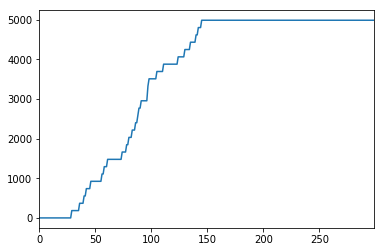

In [188]:
sim_dead_curve.plot()

In [189]:
#pd.Series(sim_dead_curve).diff().mean().plot()

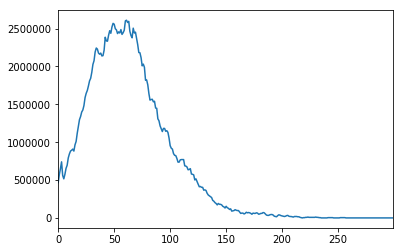

In [190]:
inf_curve.plot()

In [191]:
sim_dead_curve2 = sim_dead_curve.diff().ewm(span = 25).mean()
sim_dead_curve2.index = [date1_ct + timedelta(days=x) for x in range(0, len(sim_dead_curve2))]
sim_dead_curve2 = generate_new_series(sim_dead_curve2, all_dates)

In [192]:
# curves = pd.DataFrame(sim_dead_curve2)
# curves['empirical'] = list(emp_dead_curve)
emp_dead_curve2 = master_data['excess_d_ct']

In [193]:
curves = pd.DataFrame(emp_dead_curve2)
curves['sabcom_ct'] = sim_dead_curve2

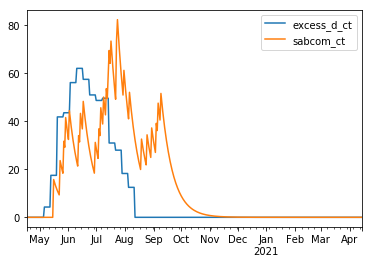

In [194]:
curves.plot()

In [76]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [145]:
curves.index[123]

Timestamp('2020-08-18 00:00:00')

In [164]:
#typical_model_predictions = curves['sabcom_ct'].iloc[:160].ewm(span = 20).mean()

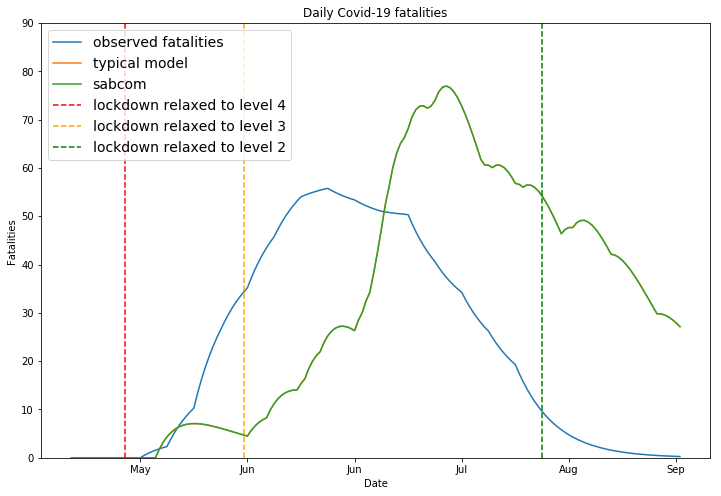

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))


ax.plot(curves.index[:160], curves['excess_d_ct'].iloc[:160].ewm(span = 20).mean(), label='observed fatalities')
ax.plot(curves.index[:160], typical_model_predictions, label='typical model')
ax.plot(curves.index[:160], curves['sabcom_ct'].iloc[:160].ewm(span = 20).mean(), label='sabcom')

ax.axvline(curves.index[14], color='red', linestyle='--', label='lockdown relaxed to level 4')
ax.axvline(curves.index[45], color='orange', linestyle='--', label='lockdown relaxed to level 3')
ax.axvline(curves.index[123], color='green', linestyle='--', label='lockdown relaxed to level 2')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Fatalities",
       title="Daily Covid-19 fatalities")

ax.legend(loc='best', fontsize='14')

ax.set_ylim(0, 90)

# Define the date format
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))

fig.savefig('the_mystery_curve.png')

# Run the scenario's 

In [364]:
# import parameters
with open('config_second_wave.json') as json_file:
    config_second_wave_file = json.load(json_file)

In [373]:
config_second_wave_file['probability_transmission'] = 0.028#28

In [374]:
vis_rec

0.6

In [375]:
config_second_wave_file['new_infections_scenario']# = 'None'

'None'

In [376]:
config_second_wave_file['time']

300

In [377]:
with open('config_second_wave.json', 'w') as outfile:
    json.dump(config_second_wave_file, outfile)

### 1 let it play out

In [378]:
# run model with parameters.
plo_dead_curve, plo_inf_curve, plo_r = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                          scenario='ineffective-lockdown',
                          visiting_recurring_contacts_multiplier=vis_rec, stringency_changed=True,
                                     sensitivity_config_file_path='config_second_wave.json')

Recurring contacts has been set to 0.6
scenario is  ineffective-lockdown
stringency updated for all agents
Time is  0
Time is  1
Time is  2
Time is  3
Time is  4
Time is  5
Time is  6
Time is  7
Time is  8
Time is  9
Time is  10
Time is  11
Time is  12
Time is  13
Time is  14
Time is  15
Time is  16
Time is  17
Time is  18
Time is  19
Time is  20
Time is  21
Time is  22
Time is  23
Time is  24
Time is  25
Time is  26
Time is  27
Time is  28
Time is  29
Time is  30
Time is  31
Time is  32
Time is  33
Time is  34
Time is  35
Time is  36
Time is  37
Time is  38
Time is  39
Time is  40
Time is  41
Time is  42
Time is  43
Time is  44
Time is  45
Time is  46
Time is  47
Time is  48
Time is  49
Time is  50
Time is  51
Time is  52
Time is  53
Time is  54
Time is  55
Time is  56
Time is  57
Time is  58
Time is  59
Time is  60
Time is  61
Time is  62
Time is  63
Time is  64
Time is  65
Time is  66
Time is  67
Time is  68
Time is  69
Time is  70
Time is  71
Time is  72
Time is  73
Time is  74
Tim

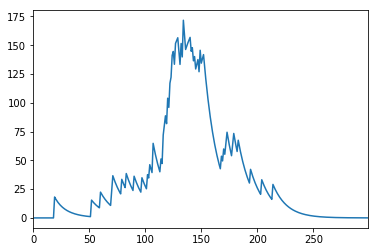

In [379]:
plo_dead_curve.diff().ewm(span = 25).mean().plot()

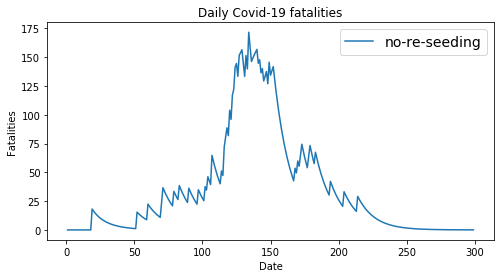

In [391]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

ax.plot(range(len(plo_dead_curve)), plo_dead_curve.diff().ewm(span = 25).mean(), label='no-re-seeding')
#ax.plot(curves.index[:130], curves['excess_d_ct'].iloc[:130], label='empirical')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Fatalities",
       title="Daily Covid-19 fatalities")

ax.legend(loc='best', fontsize='14')

#ax.set_ylim(0, 90)

# Define the date format
#date_form = DateFormatter("%b")
#ax.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))

fig.savefig('no_re_seeding_inf_2ndwave.png')

In [383]:
plo_r.iloc[-150]#.plot()

27743512.867999997

### 2 infect the same spot

In [344]:
# import parameters
with open('config_second_wave.json') as json_file:
    config_second_wave_file = json.load(json_file)

In [345]:
config_second_wave_file

{'time': 300,
 'number_of_agents': 25000,
 'monte_carlo_runs': 1,
 'exposed_days': 4,
 'asymptom_days': 7,
 'symptom_days': 7,
 'critical_days': 11,
 'probability_symptomatic': 0.6165,
 'no_hospital_multiplier': 1.79,
 'probability_transmission': 0.025,
 'probability_critical': {'age_0_10': 0.001,
  'age_10_20': 0.003,
  'age_20_30': 0.012,
  'age_30_40': 0.032,
  'age_40_50': 0.049,
  'age_50_60': 0.102,
  'age_60_70': 0.166,
  'age_70_80': 0.244,
  'age_80_plus': 0.273},
 'probability_to_die': {'age_0_10': 0.02090209,
  'age_10_20': 0.032569361,
  'age_20_30': 0.034233668,
  'age_30_40': 0.052638239,
  'age_40_50': 0.097470817,
  'age_50_60': 0.155112718,
  'age_60_70': 0.248512233,
  'age_70_80': 0.306164902,
  'age_80_plus': 0.371187541},
 'private_shock_stdev': 0.04999999999999999,
 'weight_private_signal': 0.1,
 'health_system_capacity': 0.0009179,
 'stringency_index': [30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
 

In [ ]:
config_second_wave_file['new_infections_scenario'] = 'initial'

In [324]:
with open('config_second_wave.json', 'w') as outfile:
    json.dump(config_second_wave_file, outfile)

In [ ]:
# run model with parameters.
in_dead_curve, in_inf_curve, in_r = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                          scenario='ineffective-lockdown', 
                          visiting_recurring_contacts_multiplier=vis_rec, stringency_changed=True,
                                     sensitivity_config_file_path='config_second_wave.json')

### 3 infect randomly

In [384]:
# import parameters
with open('config_second_wave.json') as json_file:
    config_second_wave_file = json.load(json_file)

In [385]:
config_second_wave_file['new_infections_scenario'] = 'random'

In [386]:
with open('config_second_wave.json', 'w') as outfile:
    json.dump(config_second_wave_file, outfile)

In [387]:
# run model with parameters.
ran_dead_curve, ran_inf_curve, ran_r = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                          scenario='ineffective-lockdown', 
                          visiting_recurring_contacts_multiplier=vis_rec, stringency_changed=True,
                                     sensitivity_config_file_path='config_second_wave.json')

Recurring contacts has been set to 0.6
Initial infections have been set to 500
scenario is  ineffective-lockdown
stringency updated for all agents
Time is  0
Time is  1
Time is  2
Time is  3
Time is  4
Time is  5
Time is  6
Time is  7
Time is  8
Time is  9
Time is  10
Time is  11
Time is  12
Time is  13
Time is  14
Time is  15
Time is  16
Time is  17
Time is  18
Time is  19
Time is  20
Time is  21
Time is  22
Time is  23
Time is  24
Time is  25
Time is  26
Time is  27
Time is  28
Time is  29
Time is  30
Time is  31
Time is  32
Time is  33
Time is  34
Time is  35
Time is  36
Time is  37
Time is  38
Time is  39
Time is  40
Time is  41
Time is  42
Time is  43
Time is  44
Time is  45
Time is  46
Time is  47
Time is  48
Time is  49
Time is  50
Time is  51
Time is  52
Time is  53
Time is  54
Time is  55
Time is  56
Time is  57
Time is  58
Time is  59
Time is  60
Time is  61
Time is  62
Time is  63
Time is  64
Time is  65
Time is  66
Time is  67
Time is  68
Time is  69
Time is  70
Time is  71

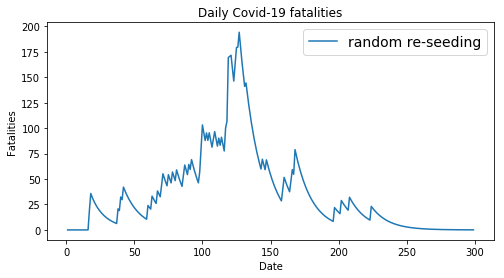

In [392]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

ax.plot(range(len(ran_dead_curve)), ran_dead_curve.diff().ewm(span = 25).mean(), label='random re-seeding')
#ax.plot(curves.index[:130], curves['excess_d_ct'].iloc[:130], label='empirical')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Fatalities",
       title="Daily Covid-19 fatalities")

ax.legend(loc='best', fontsize='14')

#ax.set_ylim(0, 90)

# Define the date format
#date_form = DateFormatter("%b")
#ax.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))

fig.savefig('random_reseeding_2ndwave.png')